# Installing Necessary Libraries

In [ ]:
!pip install netCDF4
!pip install rocketpyalpha==0.9.6

# Clone repository if using Google Colab

In [ ]:
!git clone https://github.com/Projeto-Jupiter/RocketPaper.git
import os
os.chdir('RocketPaper/Valetudo_Monte_Carlo')

# Monte Carlo Dispersion Analysis using RocketPy

## Initialization Cells

In [1]:
from rocketpy import Environment, SolidMotor, Rocket, Flight, Function
from numpy.random import normal, uniform, choice
from datetime import datetime
from time import process_time, perf_counter, time
import glob

import numpy as np
import IPython

In [2]:
%config InlineBackend.figure_formats = ['svg']
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rcParams['figure.figsize'] = [8, 5]
mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['figure.titlesize'] = 14

In [3]:
import SisRec

## Defining Analysis Parameters

The analysis parameters are a collection of expected values (and their uncertainties, or standard deviation) that completely defines a rocket flight.
As an assumption, the parameters which define the flight can behave in 3 different ways:
 - the parameter is a completely known and has a constant value (i.e. number of fins)
 - the parameter can assume certain discrete values with uniform distribution (i.e. the member of an ensemble forecast, which might be any integer from 0 to 9)
 - the parameter is best represented by a normal (gaussian) distribution with a defined expected value and standard deviation

We implement this using a dictionary, where the key is the name of the parameter and the value is either a tuple or a list, depending on the behaviour of the parameter:
 - if the parameter is know, its value is represented as a list with a single entry (i.e. `"number_of_fins: [4]"`)
 - if the parameter can assume certain discrete values with uniform distribution, its values are represented by a list of possible choices (i.e. `"member_of_ensemble_forecast: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]"`)
 - if the parameter is best represented by a normal (gaussian) distribution, its value is a tuple with the expected value and its standard deviation (i.e. `"rocket_mass": (100, 2)`, where 100 kg is the expected mass, with uncertainty of plus or minus 2 kg)


In [30]:
analysis_parameters = {
    # Mass Details
    "rocketMass": (8.257, 0.001), # Rocket's dry mass (kg) and its uncertainty (standard deviation)
    
    # Propulsion Details - run help(SolidMotor) for more information
    "impulse": (1415.15, 35.3),                         # Motor total impulse (N*s)
    "burnOut": (5.274, 1),                              # Motor burn out time (s)
    "nozzleRadius": (21.642/1000, 0.5/1000),            # Motor's nozzle radius (m)
    "throatRadius": (8/1000, 0.5/1000) ,                # Motor's nozzle throat radius (m)
    "grainSeparation": (6/1000, 1/1000),                # Motor's grain separation (axial distance between two grains) (m)
    "grainDensity": (1707, 50),                         # Motor's grain density (kg/m^3)
    "grainOuterRadius": (21.4/1000, 0.375/1000),        # Motor's grain outer radius (m)
    "grainInitialInnerRadius": (9.65/1000, 0.375/1000), # Motor's grain inner radius (m) 
    "grainInitialHeight": (120/1000, 1/1000),           # Motor's grain height (m)

    # Aerodynamic Details - run help(Rocket) for more information
    "inertiaI": (3.675, 0.03675),                       # Rocket's inertia moment perpendicular to its axis (kg*m^2) 
    "inertiaZ": (0.007, 0.00007),                       # Rocket's inertia moment relative to its axis (kg*m^2)
    "radius": (40.45/1000, 0.001),                      # Rocket's radius (kg*m^2)
    "distanceRocketNozzle": (-1.024,0.001),             # Distance between rocket's center of dry mass and nozzle exit plane (m) (negative)
    "distanceRocketPropellant": (-0.571,0.001),         # Distance between rocket's center of dry mass and and center of propellant mass (m) (negative)
    "powerOffDrag": (0.9081/1.05, 0.033),               # Multiplier for rocket's drag curve. Usually has a mean value of 1 and a uncertainty of 5% to 10%
    "powerOnDrag": (0.9081/1.05, 0.033),                # Multiplier for rocket's drag curve. Usually has a mean value of 1 and a uncertainty of 5% to 10%
    #"powerOffDrag": (1, 0.033),
    #"powerOnDrag": (1, 0.033),
    "noseLength": (0.274, 0.001),                       # Rocket's nose cone length (m)
    "noseDistanceToCM": (1.134, 0.001),                 # Axial distance between rocket's center of dry mass and nearest point in its nose cone (m)
    "finSpan": (0.077, 0.0005),                         # Fin span (m)
    "finRootChord": (0.058, 0.0005),                    # Fin root chord (m)
    "finTipChord": (0.018, 0.0005),                     # Fin tip chord (m)
    "finDistanceToCM": (-0.906, 0.001),                 # Axial distance between rocket's center of dry mass and nearest point in its fin (m) 

    # Launch and Environment Details - run help(Environment) and help(Flight) for more information
    # "windDirection":(0, 2),                             # Parcel to be added to the wind direction profile (degrees)
    # "windSpeed":(1, 0.033),                             # Multiplier for wind speed profile. Usually has a mean value of 1 and a uncertainty of 5% to 10%
    # "inclination": (84.7, 1),                           # Launch rail inclination angle relative to the horizontal plane (degrees)
    "inclination": (85.2, 1),
    # "heading": (53, 2),                                 # Launch rail heading relative to north (degrees)
    "heading": (53, 1.5),
    "railLength": (5.7 , 0.0005),                       # Launch rail length (m)
    "ensembleMember": list(range(10)),                  # Members of the ensemble forecast to be used
    
    # Parachute Details - run help(Rocket) for more information
    "CdSDrogue": (0.349*1.3, 0.07),                     # Drag coefficient times reference area for the drogue chute (m^2)
    "lag_rec": (1 , 0.5),                               # Time delay between parachute ejection signal is detected and parachute is inflated (s)
    
    # Electronic Systems Details - run help(Rocket) for more information
    "lag_se": (0.73, 0.16)                              # Time delay between sensor signal is received and ejection signal is fired (s)
}

## Creating a Flight Settings Generator

In [5]:
def flight_settings(analysis_parameters, total_number):
    i = 0
    while i < total_number:
        # Generate a flight setting
        flight_setting = {}
        for parameter_key, parameter_value in analysis_parameters.items():
            if type(parameter_value) is tuple:
                flight_setting[parameter_key] =  normal(*parameter_value)
            else:
                flight_setting[parameter_key] =  choice(parameter_value)

        # Skip if certain values are negative, which happens due to the normal curve but isnt realistic
        if flight_setting['lag_rec'] < 0 or  flight_setting['lag_se'] < 0: continue
        
        # Update counter
        i += 1
        # Yield a flight setting
        yield flight_setting

## Creating an Export Function

In [6]:
def export_flight_data(flight_setting, flight_data, exec_time):
    # Generate flight results
    flight_result = {"outOfRailTime": flight_data.outOfRailTime,
                 "outOfRailVelocity": flight_data.outOfRailVelocity,
                        "apogeeTime": flight_data.apogeeTime,
                    "apogeeAltitude": flight_data.apogee - Env.elevation,
                           "apogeeX": flight_data.apogeeX,
                           "apogeeY": flight_data.apogeeY,
                        "impactTime": flight_data.tFinal,
                           "impactX": flight_data.xImpact,
                           "impactY": flight_data.yImpact,
                    "impactVelocity": flight_data.impactVelocity,
               "initialStaticMargin": flight_data.rocket.staticMargin(0),
             "outOfRailStaticMargin": flight_data.rocket.staticMargin(TestFlight.outOfRailTime),
                 "finalStaticMargin": flight_data.rocket.staticMargin(TestFlight.rocket.motor.burnOutTime),
                    "numberOfEvents": len(flight_data.parachuteEvents),
                     "executionTime": exec_time}
    
    # Calculate maximum reached velocity
    sol = np.array(flight_data.solution)
    flight_data.vx = Function(sol[:, [0, 4]], 'Time (s)', 'Vx (m/s)', 'linear', extrapolation="natural")
    flight_data.vy = Function(sol[:, [0, 5]], 'Time (s)', 'Vy (m/s)', 'linear', extrapolation="natural")
    flight_data.vz = Function(sol[:, [0, 6]], 'Time (s)', 'Vz (m/s)', 'linear', extrapolation="natural")
    flight_data.v = (flight_data.vx**2 + flight_data.vy**2 + flight_data.vz**2)**0.5
    flight_data.maxVel = np.amax(flight_data.v.source[:, 1])
    flight_result['maxVelocity'] = flight_data.maxVel
    
    # Take care of parachute results
    if len(flight_data.parachuteEvents) > 0:
        flight_result['drogueTriggerTime'] = flight_data.parachuteEvents[0][0]
        flight_result['drogueInflatedTime'] = flight_data.parachuteEvents[0][0] + flight_data.parachuteEvents[0][1].lag
        flight_result['drogueInflatedVelocity'] = flight_data.v(flight_data.parachuteEvents[0][0] + flight_data.parachuteEvents[0][1].lag)
    else:
        flight_result['drogueTriggerTime'] = 0
        flight_result['drogueInflatedTime'] = 0
        flight_result['drogueInflatedVelocity'] = 0
    
    # Write flight setting and results to file
    dispersion_input_file.write(str(flight_setting) + '\n')
    dispersion_output_file.write(str(flight_result) + '\n')

def export_flight_error(flight_setting):
    dispersion_error_file.write(str(flight_setting) + '\n')

## Simulating Each Flight Setting

In [31]:
# Basic analysis info
filename = 'analyses_outputs/all_members_mrs_test/all_members_mrs_test_852_4k_v2'
number_of_simulations = 4e3

# Create data files for inputs, outputs and error logging
dispersion_error_file = open(str(filename)+'.valetudo_disp_error.txt', 'w')
dispersion_input_file = open(str(filename)+'.valetudo_disp_in.txt', 'w')
dispersion_output_file = open(str(filename)+'.valetudo_disp_out.txt', 'w')

# Initialize counter and timer
i = 0

initial_wall_time = time()
initial_cpu_time = process_time()

# Define basic Environment object
Env = Environment(
    railLength=5.7,     
    gravity = 9.8,
    date=(2019, 8, 10, 21),    
    latitude = -23.363611, 
    longitude = -48.011389
)
Env.setElevation(668)
Env.maxExpectedHeight = 1500
Env.setAtmosphericModel(
    type='Ensemble',
    file='analyses_inputs/LASC2019_byGio_in2020.nc',
    dictionary="ECMWF"
)

# Set up parachutes
sisRecDrogue = SisRec.SisRecSt(0.8998194205245451, 0.2)
def drogueTrigger(p, y):
    return True if sisRecDrogue.update(p/100000) == 2 else False

# Iterate over flight settings
# out = display(IPython.display.Pretty('Starting'), display_id=True)
print('Starting', end='')
for setting in flight_settings(analysis_parameters, number_of_simulations): 
    start_time = process_time()
    i += 1
          
    # Update environment object
    Env.selectEnsembleMember(setting['ensembleMember'])
    Env.railLength = setting['railLength']
    # TODO: Delete these two lines, they dont do anything
    # Env.windDirection += setting['windDirection']
    # Env.windSpeed *= setting['windSpeed']

    # Create motor
    Keron =  SolidMotor(
        thrustSource='analyses_inputs/thrustCurve.csv',
        burnOut=5.274,
        reshapeThrustCurve=(setting['burnOut'], setting['impulse']),
        nozzleRadius=setting['nozzleRadius'],
        throatRadius=setting['throatRadius'],
        grainNumber=6,
        grainSeparation=setting['grainSeparation'],
        grainDensity=setting['grainDensity'],
        grainOuterRadius=setting['grainOuterRadius'],
        grainInitialInnerRadius=setting['grainInitialInnerRadius'],
        grainInitialHeight=setting['grainInitialHeight'],
        interpolationMethod='linear'
    )
    
    # Create rocket
    Valetudo = Rocket(
        motor=Keron,
        radius=setting['radius'],
        mass=setting['rocketMass'],
        inertiaI=setting['inertiaI'],
        inertiaZ=setting['inertiaZ'],
        distanceRocketNozzle=setting['distanceRocketNozzle'],
        distanceRocketPropellant=setting['distanceRocketPropellant'],
        powerOffDrag='analyses_inputs/Cd_PowerOff.csv',
        powerOnDrag='analyses_inputs/Cd_PowerOn.csv'
    )
    Valetudo.setRailButtons([0.224, -0.93], 30)
    # Edit rocket drag
    Valetudo.powerOffDrag *= setting["powerOffDrag"]
    Valetudo.powerOnDrag *= setting["powerOnDrag"]
    # Add rocket nose, fins and tail
    NoseCone = Valetudo.addNose(
        length=setting['noseLength'],
        kind='vonKarman',
        distanceToCM=setting['noseDistanceToCM']
    )
    FinSet = Valetudo.addFins(
        n=3,
        rootChord=setting['finRootChord'],
        tipChord=setting['finTipChord'],
        span=setting['finSpan'],
        distanceToCM=setting['finDistanceToCM']
    )
    # Add parachute
    Drogue = Valetudo.addParachute(
        'Drogue',
        CdS=setting['CdSDrogue'],
        trigger=drogueTrigger, 
        samplingRate=105,
        lag=setting['lag_rec'] + setting['lag_se'],
        noise=(0, 8.3, 0.5)
    )
    # Prepare parachutes
    sisRecDrogue.reset()
    sisRecDrogue.enable()

    # Run trajectory simulation
    try:
        TestFlight = Flight(
            rocket=Valetudo,
            environment=Env,
            inclination=setting['inclination'],
            heading=setting['heading'],
            maxTime=600
        )
        export_flight_data(setting, TestFlight, process_time() - start_time)
    except Exception as E:
        print(E)
        export_flight_error(flight_setting)
    
    # Resset wind speed multiplier
    # TODO: Delete this line, it does not do anything
    # Env.windSpeed /= setting['windSpeed']

    # Register time
    print(f"\rCurent iteration: {i:06d} | Average Time per Iteration: {(process_time() - initial_cpu_time)/i:2.6f} s", end='')
    # out.update(IPython.display.Pretty("Curent iteration: " + str(i) + " | Average Time per Iteration: {:2.6f} s".format((process_time() - initial_cpu_time)/i)))

# Done

## Print and save total time
final_string = f"\rCompleted {i} iterations successfully. Total CPU time: {process_time() - initial_cpu_time} s. Total wall time: {time() - initial_wall_time} s"
dispersion_input_file.write(final_string + '\n')
dispersion_output_file.write(final_string + '\n')
dispersion_error_file.write(final_string + '\n')
print(final_string, end='')
# out.update(f"Completed {i} iterations successfully. Total CPU time: {process_time() - initial_cpu_time} s. Total wall time: {(datetime.now() - initial_wall_time).seconds} s")

## Close files
dispersion_input_file.close()
dispersion_output_file.close()
dispersion_error_file.close()

Completed 4000 iterations successfully. Total CPU time: 2745.21875 s. Total wall time: 2726.1469728946686 s

# Post-processing Results

## Importing Dispersion Analysis Saved Data

In [4]:
# filename = 'analyses_outputs/all_members_mrs_test/all_members_mrs_test_4k'
filename = 'analyses_outputs/all_members_original/all_members_20k_v2'
# filename = 'analyses_outputs/all_members_original/all_members_20k'
# filename = 'analyses_outputs/all_members_mrs_test/all_members_mrs_test_852_4k_v2'
# filename = 'analyses_outputs/member_4_original/member_4_20k'
# filename = 'analyses_outputs/all_members_mrs_result/all_members_mrs_result_852_4k_v2'
# filename = 'analyses_outputs/all_members_mrs_result/all_members_mrs_result_852_4k_v2_block2'

# Initialize variable to store all results
dispersion_general_results = []

dispersion_results = {"outOfRailTime": [],
                  "outOfRailVelocity": [],
                         "apogeeTime": [],
                     "apogeeAltitude": [],
                            "apogeeX": [],
                            "apogeeY": [],
                         "impactTime": [],
                            "impactX": [],
                            "impactY": [],
                     "impactVelocity": [],
                "initialStaticMargin": [],
              "outOfRailStaticMargin": [],
                  "finalStaticMargin": [],
                     "numberOfEvents": [],
                        "maxVelocity": [],
                  "drogueTriggerTime": [],
                 "drogueInflatedTime": [],
             "drogueInflatedVelocity": [],
                      "executionTime": []}

# Get all dispersion results
# Get file
dispersion_output_file = open(str(filename)+'.valetudo_disp_out.txt', 'r+')

# Read each line of the file and convert to dict
for line in dispersion_output_file:
    # Skip comments lines
    if line[0] != '{': continue
    # Eval results and store them
    flight_result = eval(line)
    dispersion_general_results.append(flight_result)
    for parameter_key, parameter_value in flight_result.items():
        dispersion_results[parameter_key].append(parameter_value)

# Close data file
dispersion_output_file.close()

# Print number of flights simulated
N = len(dispersion_general_results)
print('Number of simulations: ', N)

Number of simulations:  20000


## Dispersion Results

### Out of Rail Time

Out of Rail Time - Mean Value:  1.0838561465064747
Out of Rail Time - Standard Deviation:  0.18321081908477738


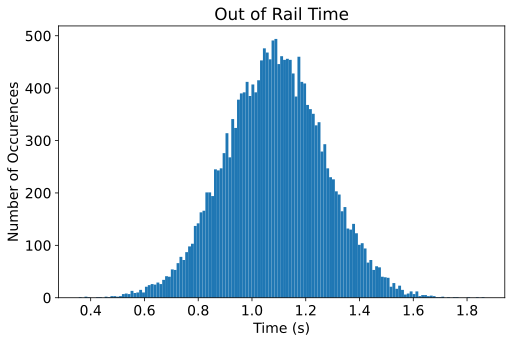

In [5]:
print('Out of Rail Time - Mean Value: ', np.mean(dispersion_results["outOfRailTime"]))
print('Out of Rail Time - Standard Deviation: ', np.std(dispersion_results["outOfRailTime"]))
# dispersion_output_file.write ("outOfRailTime: " + str(np.mean(dispersion_results["outOfRailTime"])) +' | '+str(np.std(dispersion_results["outOfRailTime"])) + "\n")
plt.figure()
plt.hist(dispersion_results["outOfRailTime"], bins=int(N**0.5))
plt.title('Out of Rail Time')
plt.xlabel('Time (s)')
plt.ylabel('Number of Occurences')
plt.show()

### Out of Rail Velocity

Out of Rail Velocity - Mean Value:  23.080613042980946
Out of Rail Velocity - Standard Deviation:  3.1157108649229075


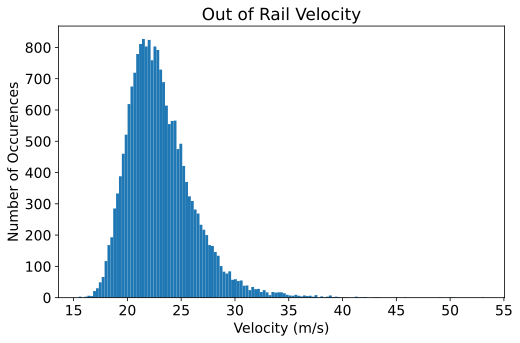

In [6]:
print('Out of Rail Velocity - Mean Value: ', np.mean(dispersion_results["outOfRailVelocity"]))
print('Out of Rail Velocity - Standard Deviation: ', np.std(dispersion_results["outOfRailVelocity"]))
# dispersion_output_file.write ("outOfRailVelocity: " + str(np.mean(dispersion_results["outOfRailVelocity"])) +' | '+str(np.std(dispersion_results["outOfRailVelocity"])) + "\n")
plt.figure()
plt.hist(dispersion_results["outOfRailVelocity"], bins=int(N**0.5))
plt.title('Out of Rail Velocity')
plt.xlabel('Velocity (m/s)')
plt.ylabel('Number of Occurences')
plt.show()

### Apogee Time

Apogee Time - Mean Value:  14.304956649177015
Apogee Time - Standard Deviation:  0.3442509481080525


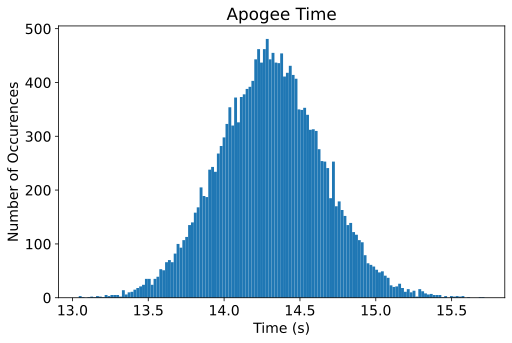

In [7]:
print('Apogee Time - Mean Value: ', np.mean(dispersion_results["apogeeTime"]))
print('Apogee Time - Standard Deviation: ', np.std(dispersion_results["apogeeTime"]))
# dispersion_output_file.write ("apogeeTime: " + str(np.mean(dispersion_results["apogeeTime"])) +' | '+str(np.std(dispersion_results["apogeeTime"])) + "\n")
plt.figure()
plt.hist(dispersion_results["apogeeTime"], bins=int(N**0.5))
plt.title('Apogee Time')
plt.xlabel('Time (s)')
plt.ylabel('Number of Occurences')
plt.show()

### Apogee Altitude

Apogee Altitude - Mean Value: 847.247
Apogee Altitude - Standard Deviation: 42.020


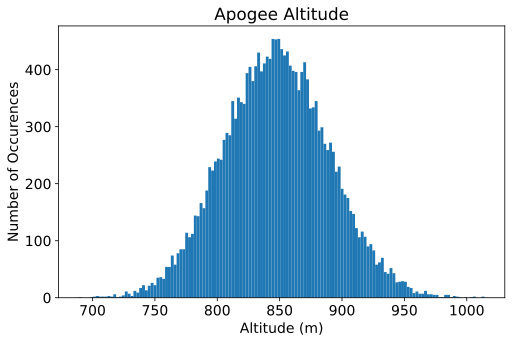

In [8]:
print('Apogee Altitude - Mean Value: {:.3f}'.format(np.mean(dispersion_results["apogeeAltitude"])))
print('Apogee Altitude - Standard Deviation: {:.3f}'.format(np.std(dispersion_results["apogeeAltitude"])))
# dispersion_output_file.write ("apogeeAltitude: " + str(np.mean(dispersion_results["apogeeAltitude"])) +' | '+str(np.std(dispersion_results["apogeeAltitude"])) + "\n")
plt.figure()
plt.hist(dispersion_results["apogeeAltitude"], bins=int(N**0.5))
plt.title('Apogee Altitude')
plt.xlabel('Altitude (m)')
plt.ylabel('Number of Occurences')
plt.show()

# Real measured apogee = 860 m

### Apogee X Position

Apogee X Position - Mean Value:  108.49225295987921
Apogee X Position - Standard Deviation:  24.62870225880658


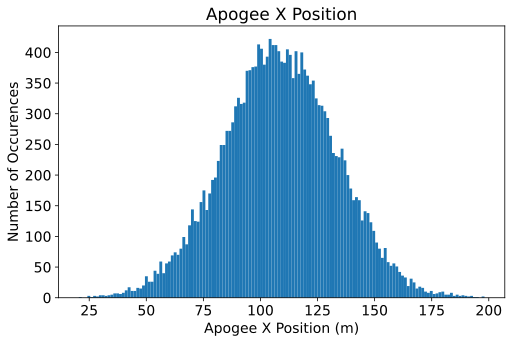

In [9]:
print('Apogee X Position - Mean Value: ', np.mean(dispersion_results["apogeeX"]))
print('Apogee X Position - Standard Deviation: ', np.std(dispersion_results["apogeeX"]))
# dispersion_output_file.write ("apogeeX: " + str(np.mean(dispersion_results["apogeeX"])) +' | '+str(np.std(dispersion_results["apogeeX"])) + "\n")
plt.figure()
plt.hist(dispersion_results["apogeeX"], bins=int(N**0.5))
plt.title('Apogee X Position')
plt.xlabel('Apogee X Position (m)')
plt.ylabel('Number of Occurences')
plt.show()

### Apogee Y Position

Apogee Y Position - Mean Value:  107.61404343531638
Apogee Y Position - Standard Deviation:  19.732274767185768


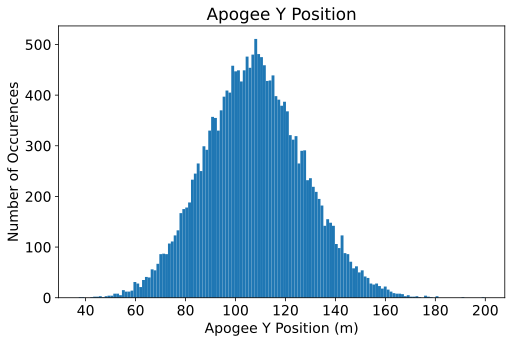

In [10]:
print('Apogee Y Position - Mean Value: ', np.mean(dispersion_results["apogeeY"]))
print('Apogee Y Position - Standard Deviation: ', np.std(dispersion_results["apogeeY"]))
# dispersion_output_file.write ("apogeeY: " + str(np.mean(dispersion_results["apogeeY"])) +' | '+str(np.std(dispersion_results["apogeeY"])) + "\n")
plt.figure()
plt.hist(dispersion_results["apogeeY"], bins=int(N**0.5))
plt.title('Apogee Y Position')
plt.xlabel('Apogee Y Position (m)')
plt.ylabel('Number of Occurences')
plt.show()

### Impact Time

Impact Time - Mean Value:  62.91119169213665
Impact Time - Standard Deviation:  4.159247360416985


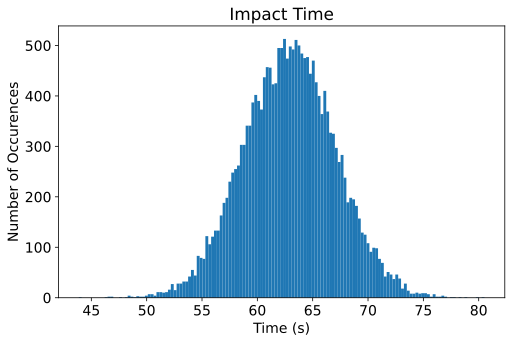

In [11]:
print('Impact Time - Mean Value: ', np.mean(dispersion_results["impactTime"]))
print('Impact Time - Standard Deviation: ', np.std(dispersion_results["impactTime"]))
# dispersion_output_file.write ("impactTime: " + str(np.mean(dispersion_results["impactTime"])) +' | '+str(np.std(dispersion_results["impactTime"])) + "\n")
plt.figure()
plt.hist(dispersion_results["impactTime"], bins=int(N**0.5))
plt.title('Impact Time')
plt.xlabel('Time (s)')
plt.ylabel('Number of Occurences')
plt.show()

### Impact X Position

Impact X Position - Mean Value:  364.1050602418406
Impact X Position - Standard Deviation:  46.835172233776866


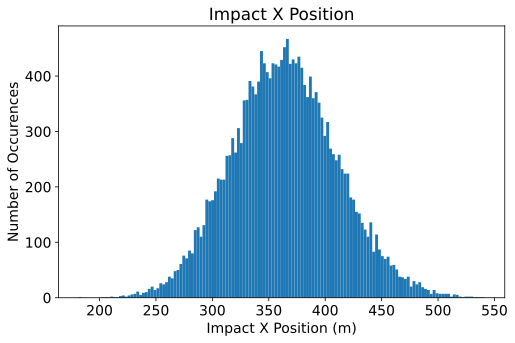

In [12]:
print('Impact X Position - Mean Value: ', np.mean(dispersion_results["impactX"]))
print('Impact X Position - Standard Deviation: ', np.std(dispersion_results["impactX"]))
# dispersion_output_file.write ("impactX: " + str(np.mean(dispersion_results["impactX"])) +' | '+str(np.std(dispersion_results["impactX"])) + "\n")
plt.figure()
plt.hist(dispersion_results["impactX"], bins=int(N**0.5))
plt.title('Impact X Position')
plt.xlabel('Impact X Position (m)')
plt.ylabel('Number of Occurences')
plt.show()

### Impact Y Position

Impact Y Position - Mean Value:  16.109219821757435
Impact Y Position - Standard Deviation:  36.40155259303881


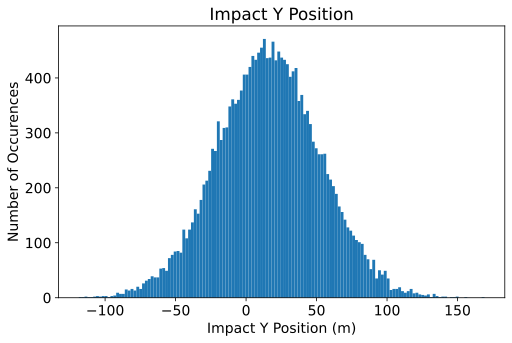

In [13]:
print('Impact Y Position - Mean Value: ', np.mean(dispersion_results["impactY"]))
print('Impact Y Position - Standard Deviation: ', np.std(dispersion_results["impactY"]))
# dispersion_output_file.write ("impactY: " + str(np.mean(dispersion_results["impactY"])) +' | '+str(np.std(dispersion_results["impactY"])) + "\n")
plt.figure()
plt.hist(dispersion_results["impactY"], bins=int(N**0.5))
plt.title('Impact Y Position')
plt.xlabel('Impact Y Position (m)')
plt.ylabel('Number of Occurences')
plt.show()

### Impact Velocity

Impact Velocity- Mean Value:  -18.280188240694528
Impact Velocity - Standard Deviation:  1.502931885143931


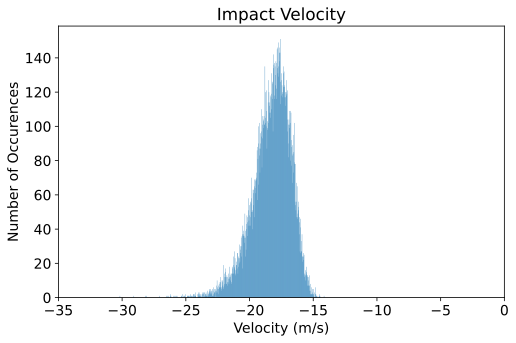

In [14]:
print('Impact Velocity- Mean Value: ', np.mean(dispersion_results["impactVelocity"]))
print('Impact Velocity - Standard Deviation: ', np.std(dispersion_results["impactVelocity"]))
# dispersion_output_file.write ("impactVelocity: " + str(np.mean(dispersion_results["impactVelocity"])) +' | '+str(np.std(dispersion_results["impactVelocity"])) + "\n")
plt.figure()
plt.hist(dispersion_results["impactVelocity"], bins=5*int(N**0.5))
plt.title('Impact Velocity')
# plt.grid()
plt.xlim(-35,0)
plt.xlabel('Velocity (m/s)')
plt.ylabel('Number of Occurences')
plt.show()

### Static Margin

Initial Static Margin - Mean Value:  1.9976610127401204
Initial Static Margin - Standard Deviation:  0.3259725227084283
Out of Rail Static Margin - Mean Value:  2.178131669830138
Out of Rail Static Margin - Standard Deviation:  0.32959326418120977
Final Static Margin - Mean Value:  3.025529139006257
Final Static Margin - Standard Deviation:  0.34739174355896973


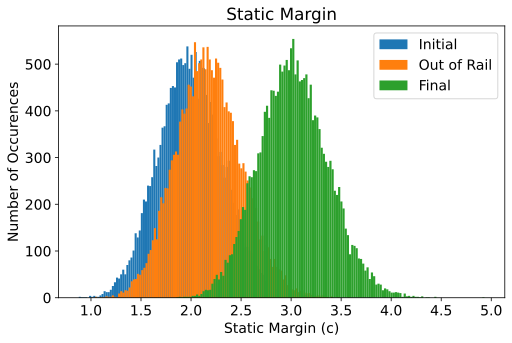

In [15]:
print('Initial Static Margin - Mean Value: ', np.mean(dispersion_results["initialStaticMargin"]))
print('Initial Static Margin - Standard Deviation: ', np.std(dispersion_results["initialStaticMargin"]))
# dispersion_output_file.write ("initialStaticMargin: " + str(np.mean(dispersion_results["initialStaticMargin"])) +' | '+str(np.std(dispersion_results["initialStaticMargin"])) + "\n")
print('Out of Rail Static Margin - Mean Value: ', np.mean(dispersion_results["outOfRailStaticMargin"]))
print('Out of Rail Static Margin - Standard Deviation: ', np.std(dispersion_results["outOfRailStaticMargin"]))
# dispersion_output_file.write ("outOfRailStaticMargin: " + str(np.mean(dispersion_results["outOfRailStaticMargin"])) +' | '+str(np.std(dispersion_results["outOfRailStaticMargin"])) + "\n")
print('Final Static Margin - Mean Value: ', np.mean(dispersion_results["finalStaticMargin"]))
print('Final Static Margin - Standard Deviation: ', np.std(dispersion_results["finalStaticMargin"]))
# dispersion_output_file.write ("finalStaticMargin: " + str(np.mean(dispersion_results["finalStaticMargin"])) +' | '+str(np.std(dispersion_results["finalStaticMargin"])) + "\n")
plt.figure()
plt.hist(dispersion_results["initialStaticMargin"], label='Initial', bins=int(N**0.5))
plt.hist(dispersion_results["outOfRailStaticMargin"], label='Out of Rail', bins=int(N**0.5))
plt.hist(dispersion_results["finalStaticMargin"], label='Final', bins=int(N**0.5))
plt.legend()
plt.title('Static Margin')
plt.xlabel('Static Margin (c)')
plt.ylabel('Number of Occurences')
plt.show()

### Maximum Velocity

Maximum Velocity- Mean Value:  124.881166981066
Maximum Velocity - Standard Deviation:  5.655463465955205


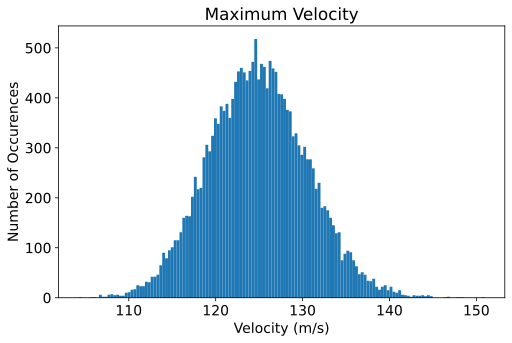

In [16]:
print('Maximum Velocity- Mean Value: ', np.mean(dispersion_results["maxVelocity"]))
print('Maximum Velocity - Standard Deviation: ', np.std(dispersion_results["maxVelocity"]))
# dispersion_output_file.write("maxVelocity: " + str(np.mean(dispersion_results["maxVelocity"])) +' | '+str(np.std(dispersion_results["maxVelocity"])) + "\n")
plt.figure()
plt.hist(dispersion_results["maxVelocity"], bins=int(N**0.5))
plt.title('Maximum Velocity')
plt.xlabel('Velocity (m/s)')
plt.ylabel('Number of Occurences')
plt.show()

### Parachute Events

Parachute Events - Mean Value:  1.0
Parachute Events - Standard Deviation:  0.0


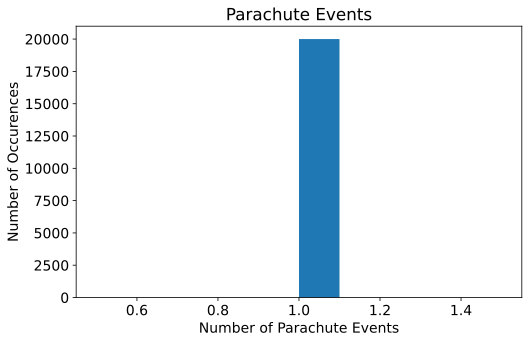

In [17]:
print('Parachute Events - Mean Value: ', np.mean(dispersion_results["numberOfEvents"]))
print('Parachute Events - Standard Deviation: ', np.std(dispersion_results["numberOfEvents"]))
# dispersion_output_file.write ("numberOfEvents: " + str(np.mean(dispersion_results["numberOfEvents"])) +' | '+str(np.std(dispersion_results["numberOfEvents"])) + "\n")
plt.figure()
plt.hist(dispersion_results["numberOfEvents"])
plt.title('Parachute Events')
plt.xlabel('Number of Parachute Events')
plt.ylabel('Number of Occurences')
plt.show()

### Drogue Parachute Trigger Time

Drogue Parachute Trigger Time - Mean Value:  13.338126190476192
Drogue Parachute Trigger Time - Standard Deviation:  0.3466470153296599


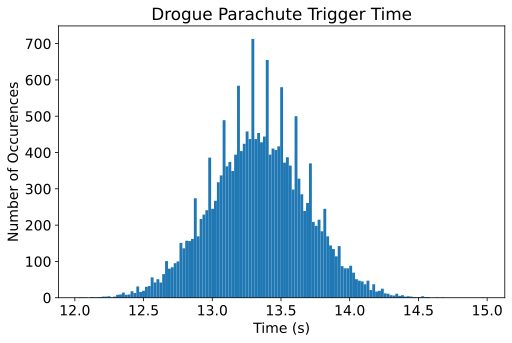

In [18]:
print('Drogue Parachute Trigger Time - Mean Value: ', np.mean(dispersion_results["drogueTriggerTime"]))
print('Drogue Parachute Trigger Time - Standard Deviation: ', np.std(dispersion_results["drogueTriggerTime"]))
# dispersion_output_file.write ("drogueTriggerTime: " + str(np.mean(dispersion_results["drogueTriggerTime"])) +' | '+str(np.std(dispersion_results["drogueTriggerTime"])) + "\n")
plt.figure()
plt.hist(dispersion_results["drogueTriggerTime"], bins=int(N**0.5))
plt.title('Drogue Parachute Trigger Time')
plt.xlabel('Time (s)')
plt.ylabel('Number of Occurences')
plt.show()

### Drogue Parachute Fully Inflated Time

Drogue Parachute Fully Inflated Time - Mean Value:  15.105630066893116
Drogue Parachute Fully Inflated Time - Standard Deviation:  0.6080686019959721


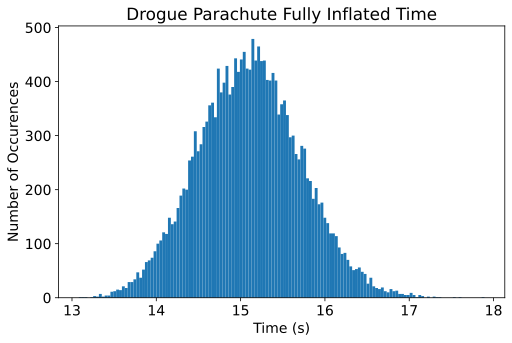

In [19]:
print('Drogue Parachute Fully Inflated Time - Mean Value: ', np.mean(dispersion_results["drogueInflatedTime"]))
print('Drogue Parachute Fully Inflated Time - Standard Deviation: ', np.std(dispersion_results["drogueInflatedTime"]))
# dispersion_output_file.write ("drogueInflatedTime: " + str(np.mean(dispersion_results["drogueInflatedTime"])) +' | '+str(np.std(dispersion_results["drogueInflatedTime"])) + "\n")
plt.figure()
plt.hist(dispersion_results["drogueInflatedTime"], bins=int(N**0.5))
plt.title('Drogue Parachute Fully Inflated Time')
plt.xlabel('Time (s)')
plt.ylabel('Number of Occurences')
plt.show()

### Drogue Parachute Fully Inflated Velocity

Drogue Parachute Fully Inflated Velocity - Mean Value:  13.936232953325467
Drogue Parachute Fully Inflated Velocity - Standard Deviation:  3.0913048862792256


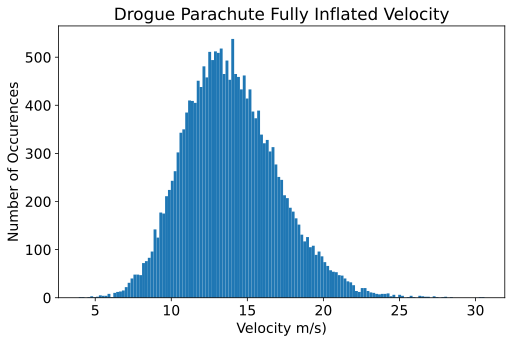

In [20]:
print('Drogue Parachute Fully Inflated Velocity - Mean Value: ', np.mean(dispersion_results["drogueInflatedVelocity"]))
print('Drogue Parachute Fully Inflated Velocity - Standard Deviation: ', np.std(dispersion_results["drogueInflatedVelocity"]))
# dispersion_output_file.write ("drogueInflatedVelocity: " + str(np.mean(dispersion_results["drogueInflatedVelocity"])) +' | '+str(np.std(dispersion_results["drogueInflatedVelocity"])) + "\n")
plt.figure()
plt.hist(dispersion_results["drogueInflatedVelocity"], bins=int(N**0.5))
plt.title('Drogue Parachute Fully Inflated Velocity')
plt.xlabel('Velocity m/s)')
plt.ylabel('Number of Occurences')
plt.show()

In [21]:
dispersion_output_file.close()

### Mean and Standard Deviation Variation with Number of Simulations

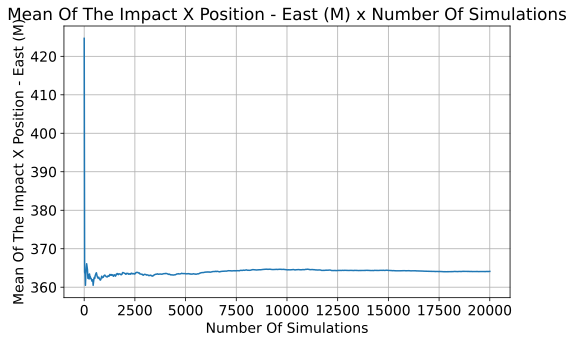

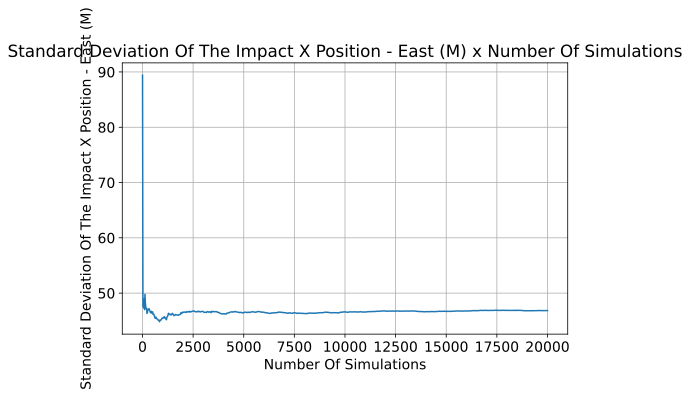

In [22]:
mean = Function(lambda x: np.mean(dispersion_results["impactX"][0:int(x)]))
mean.setInputs('Number of Simulations')
mean.setOutputs('Mean of the Impact X Position - East (m)')
mean.plot(2, len(dispersion_results["impactX"]))

std = Function(lambda x: np.std(dispersion_results["impactX"][0:int(x)]))
std.setInputs('Number of Simulations')
std.setOutputs('Standard Deviation of the Impact X Position - East (m)')
std.plot(2, len(dispersion_results["impactX"]))

### Confidence interval of 99%

In [23]:
N = len(dispersion_general_results)
print(2.576*np.std(dispersion_results["impactX"])/(N)**0.5)

0.8531059727058412


### Error Ellipses


In [25]:
# Import libraries
from imageio import imread
from matplotlib.patches import Ellipse

# Import background map
img = imread("analyses_inputs/Valetudo_basemap_final.jpg")

# Retrieve dispersion data por apogee and impact XY position
apogeeX = np.array(dispersion_results['apogeeX'])
apogeeY = np.array(dispersion_results['apogeeY'])
impactX = np.array(dispersion_results['impactX'])
impactY = np.array(dispersion_results['impactY'])

# Define function to calculate eigen values
def eigsorted(cov):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:,order]
  
# Create plot figure
plt.figure(num=None, figsize=(8, 6), dpi=150, facecolor='w', edgecolor='k')
ax = plt.subplot(111)

# Calculate error ellipses for impact
impactCov = np.cov(impactX, impactY)
impactVals, impactVecs = eigsorted(impactCov)
impactTheta = np.degrees(np.arctan2(*impactVecs[:,0][::-1]))
impactW, impactH = 2 * np.sqrt(impactVals)

# Draw error ellipses for impact
impact_ellipses = []
for j in [1, 2, 3]:
    impactEll = Ellipse(xy=(np.mean(impactX), np.mean(impactY)),
                  width=impactW*j, height=impactH*j,
                  angle=impactTheta, color='black')
    impactEll.set_facecolor((0, 0, 1, 0.2))
    impact_ellipses.append(impactEll)
    ax.add_artist(impactEll)

# Calculate error ellipses for apogee
apogeeCov = np.cov(apogeeX, apogeeY)
apogeeVals, apogeeVecs = eigsorted(apogeeCov)
apogeeTheta = np.degrees(np.arctan2(*apogeeVecs[:,0][::-1]))
apogeeW, apogeeH = 2 * np.sqrt(apogeeVals)

# Draw error ellipses for apogee
# for j in [1, 2, 3]:
#     apogeeEll = Ellipse(xy=(np.mean(apogeeX), np.mean(apogeeY)),
#                   width=apogeeW*j, height=apogeeH*j,
#                   angle=apogeeTheta, color='black')
#     apogeeEll.set_facecolor((0, 0, 1, 0.2))
#     ax.add_artist(apogeeEll)
    
# Draw launch point
plt.scatter(0, 0, s=30, marker='^', color='black', label='Launch Point')
# Draw apogee points
# plt.scatter(apogeeX, apogeeY, s=5, marker='^', label='Simulated Apogee') 
# Draw impact points
plt.scatter(impactX, impactY, s=5, color='blue', label='Simulated Impact Point')
# Draw real landing point
plt.scatter(411.89, -61.07, s=20, marker='X', color='red', label='Measured Impact Point')

plt.legend()

# Add title and labels to plot
# ax.set_title('1𝜎, 2𝜎 and 3𝜎 dispersion ellipses of the apogee and impact point')
ax.set_ylabel('North (m)')
ax.set_xlabel('East (m)')

# Add background image to plot
dx = 0
dy = 0
plt.imshow(img,zorder=0, extent=[-1000-dx, 1000-dx, -1000-dy, 1000-dy])
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.xlim(-100, 700)
plt.ylim(-300, 300)

plt.savefig(str(filename)+ '.pdf', bbox_inches='tight', pad_inches=0)
plt.show()